# System identification



In this notebook we will take a look at some simple system identifiaction tools on the Hawk data. Specifically we will look at rational fraction decomposition (RFP) (frquency domain) and stochastic subspace identification (SSI) (time domain). Both of these are 

It is highly encouraged to play with the parameters in this notebook. In order to see the results on different parts of the hawk structure. If you are unfamiliar with the `hawk` package then check out the `usage` notebook.

In [1]:
import numpy as np
from scipy.signal import csd, butter, filtfilt
import matplotlib.pyplot as plt
import seaborn as sns
from hawk import SBW
from pyma.oma import ssi # An operational modal analysis module developed by Tim Rogers https://github.com/TimothyRogers/pyMA

sns.set_theme("paper")
sns.set_style("ticks")
sns.set_palette("Set2")

# control wether figs should be saved
save = True
save_dir = './figures/'

## Rational fraction polynomial decomposition (RFP)

Rational fraction decompostion is a 'curve fitting' approach that attempts to formualte the FRF identification as a least squares problem. More detail on the implementation of the method can be found [here](http://papers.vibetech.com/Paper07-ParameterEstimationUsingRationalFractionPolynomials.pdf). 

Note that there is a known error in the orthogonal polynimoal basis part of this paper... do with that what you will.

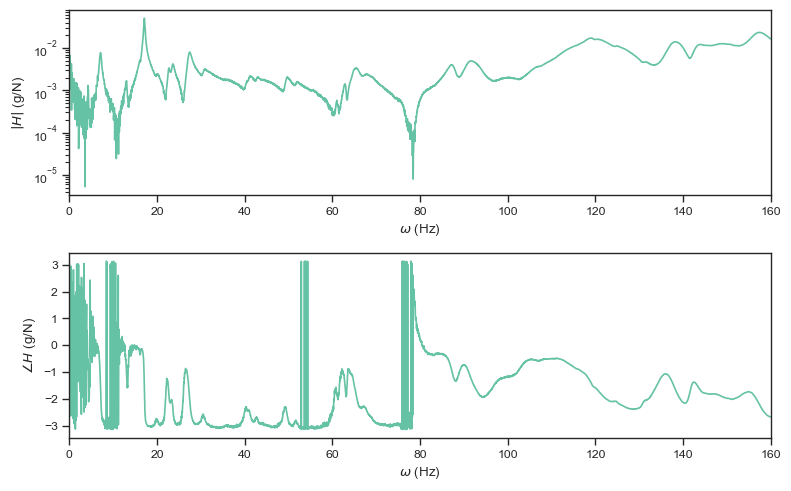

In [2]:

### You should experiment with these:
data_dir = './hawk_data'
series = 'BR_AR'
repeat = '01'
sensor = "LTC-05"
###

# Access the Hawk data
data = SBW(data_dir)

frfs_data = data[f"/LMS/{series}/{repeat}/{sensor}/frf"]
H = frfs_data[:].mean(1) # Take the mean over each LMS reptetition to improve SNR

fs_data = data["/LMS/xData/freq"]
fs = fs_data[:]

# plot the FRF
fig, axs = plt.subplots(2, 1, figsize=(8, 5))
axs[0].semilogy(fs, np.abs(H))
axs[1].plot(fs, np.angle(H))
axs[0].set_xlabel(f"$\\omega$ ({fs_data.attrs['units']})")
axs[1].set_xlabel(f"$\\omega$ ({fs_data.attrs['units']})")
axs[0].set_ylabel(f"$|H|$ ({frfs_data.attrs['units']})") 
axs[1].set_ylabel(f"$\\angle H$ ({frfs_data.attrs['units']})")
axs[0].set_xlim([0, 160])
axs[1].set_xlim([0, 160])
plt.tight_layout()
if save:
    plt.savefig(save_dir+'frf_1.png')


In [3]:
# %% implement RFP


# Hermitian transpose
def HT(a):
    return a.conj().T


# Rational fraction polynomial model
def RFP(H, w, n_modes, oob_terms=0):
    # Specify the orders of our approximation
    m = (
        n_modes * 2 + 1 + oob_terms
    )  # number of coefficients in the numerator polynomial
    n = (
        n_modes * 2 + 1
    )  # number of coefficients in the denominator -1 because we fix b_n=1

    # complex frequency vector
    iw = 1j * w

    # Build monomial basis matricies
    Phi_a = iw[:, None] ** np.arange(m)
    Phi_b_all = iw[:, None] ** np.arange(n)
    Phi_b = Phi_b_all[:, :-1]  # ignore last column because bn=1

    # preallocate some calculations for speed
    Phi_bH = Phi_b * H[:, None]
    Hiwn = H * Phi_b_all[:, -1]
    D = -HT(Phi_a) @ (Phi_bH)

    # form the block matricies
    M = np.block([[HT(Phi_a) @ Phi_a, D], [D.T, HT(Phi_bH) @ (Phi_bH)]])
    x = np.block([HT(Phi_a) @ Hiwn, -HT(Phi_bH) @ Hiwn])

    # Solve and extract the coefficients of the polynomials
    AB = np.linalg.solve(np.real(M), np.real(x))
    a = AB[:m, None]
    b = np.append(AB[m:], 1)[:, None]

    # Generate the predicted FRF
    H_pred = (Phi_a @ a) / (Phi_b_all @ b)

    # Pull out the modal porperties
    roots_b = sorted(np.roots(np.flip(b[:, 0])))[
        ::-2
    ]  # remove every other becaus they are conj pairs
    wns = np.abs(roots_b)
    zetas = -np.real(roots_b) / wns
    return H_pred, wns, zetas

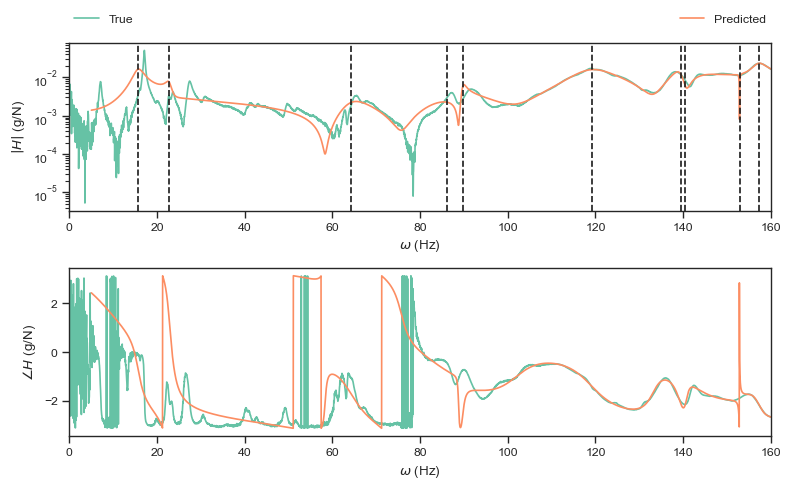

In [4]:
# fit RFP model

### you should experiment with these:
modes = 10
oob = 0
w_low = 5
w_high = 160
###

# fit the model
idx = np.logical_and(fs > w_low, fs < w_high)
H_pred, wns_pred, zetas_pred = RFP(H[idx], fs_data[idx], n_modes=modes, oob_terms=oob)

# plot the FRF
fig, axs = plt.subplots(2, 1, figsize=(8, 5))
axs[0].semilogy(fs, np.abs(H), label="True")
axs[0].semilogy(fs[idx], np.abs(H_pred), label="Predicted")
axs[1].plot(fs, np.angle(H), label="True")
axs[1].plot(fs[idx], np.angle(H_pred), label="Predicted")
[axs[0].axvline(x, c="k", ls="--") for x in wns_pred]
axs[0].set_xlabel(f"$\\omega$ ({fs_data.attrs['units']})")
axs[1].set_xlabel(f"$\\omega$ ({fs_data.attrs['units']})")
axs[0].set_ylabel(f"$|H|$ ({frfs_data.attrs['units']})")
axs[1].set_ylabel(f"$\\angle H$ ({frfs_data.attrs['units']})")
axs[0].set_xlim([0, 160])
axs[1].set_xlim([0, 160])
axs[0].legend(
    bbox_to_anchor=(0, 1.2, 1, 0),
    loc="upper left",
    ncols=2,
    mode="expand",
    borderaxespad=0,
    frameon=False,
)
plt.tight_layout()
if save:
    plt.savefig(save_dir+'frf_rfp.png')


RFP requires a lot of fiddling with the parameters in order to get a good fit to the data. 

One option is to only apply RFP in discrete frequency intervals.

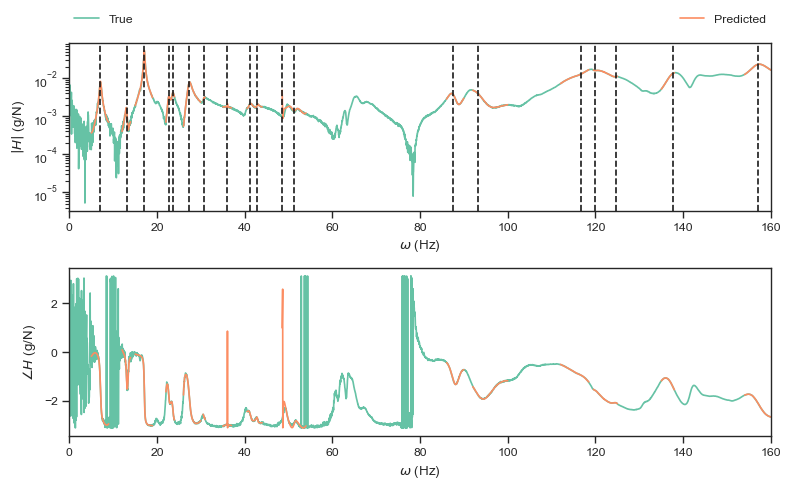

In [5]:
# fit RFP models to sections of the FRF independently

### You should experiment with these:
oob = 6
ranges = (  # (w_low, w_high), n_modes_in_range
    ((5, 9), 1),
    ((12, 14), 1),
    ((15, 19), 1),
    ((22, 24), 2),
    ((26, 30), 1),
    ((30.5, 31), 1),
    ((35, 37), 1),
    ((40.5, 44), 2),
    ((48.5, 54), 2),
    ((86, 90), 1),
    ((92, 100), 1),
    ((112, 118.5), 1),
    ((119.5, 122), 1),
    ((122, 125), 1),
    ((135, 138), 1),
    ((154, 162), 1),
)
### Challenge: see if you can ID the mode (?) at 70Hz


def get_wns(ranges, H, w, oob=0):
    zts = []
    wns = []
    H_pred = np.zeros_like(H) * np.nan
    for (low, high), n in ranges:
        idx = np.logical_and(w > low, w < high)
        Hp, wn, zs = RFP(H[idx], w[idx], n, oob_terms=oob)
        H_pred[idx] = np.squeeze(Hp)
        wns.extend(wn)
        zts.extend(zs)
    return H_pred, np.array(wns), np.array(zts)


# fit the model
H_pred, wns_pred, zetas_pred = get_wns(ranges, H, fs, oob=oob)

# plot the FRF
fig, axs = plt.subplots(2, 1, figsize=(8, 5))
axs[0].semilogy(fs, np.abs(H), label="True")
axs[0].semilogy(fs, np.abs(H_pred), label="Predicted")
axs[1].plot(fs, np.angle(H), label="True")
axs[1].plot(fs, np.angle(H_pred), label="Predicted")
[axs[0].axvline(x, c="k", ls="--") for x in wns_pred]
axs[0].set_xlabel(f"$\\omega$ ({fs_data.attrs['units']})")
axs[1].set_xlabel(f"$\\omega$ ({fs_data.attrs['units']})")
axs[0].set_ylabel(f"$|H|$ ({frfs_data.attrs['units']})")
axs[1].set_ylabel(f"$\\angle H$ ({frfs_data.attrs['units']})")
axs[0].set_xlim([0, 160])
axs[1].set_xlim([0, 160])
axs[0].legend(
    bbox_to_anchor=(0, 1.2, 1, 0),
    loc="upper left",
    ncols=2,
    mode="expand",
    borderaxespad=0,
    frameon=False,
)
plt.tight_layout()
if save:
    plt.savefig(save_dir+'frf_rfp_ranged.png')

# note that without computing the modeshapes we cannot reconstruct the entire FRF.

RFP can do well for a couple of well-seperated peaks. However getting a more comprehensive model is tricky.

Accessing the modeshapes is possible but requires more analysis.

Several other more 'advanced' FRF curve fitting algorithms are available, for example:

- Polyreference least squares complex frequency domain estimator
- Maximum liklihood modal method
- Unified matrix polynomial method

#### SSI

SSI is a time domain method and so we will use data from the NI test campaign on the hawk.

In this notebook we will use the SSI implementation provided by `pyMA` [here](https://github.com/TimothyRogers/pyMA).

In [6]:
# Load some NI time series data

### You should experiment with these:
series = "RPH_AR"  # Random phase amplitude ramp
repeat = "01"
###

# Access the Hawk data
data = SBW(data_dir)
test = data[f"/NI/{series}/{repeat}"]

# Grab the tem series for all the sensors excpt the tri-axial, shaker and EXH.
Y = np.array(
    [
        s["acc"][:,0] # Taking the first repeat only
        for k, s in test.items()
        if k[:3] not in {"EXH", "FRC", "TRI"}
    ]
)
Y = (Y.T - Y.mean(1)).T  # remove mean to remove sensor offset errors

dt = 1 / int(test.describe()["acquisitionSampleRate"])
ts = np.linspace(0, dt * Y.shape[1], num=Y.shape[1])  # Dummy time vector


# plot the time series
plt.figure(figsize=(8, 5))
plt.plot(ts, Y.T)
plt.xlabel(f"Time")
plt.ylabel(f"Acceleration")
if save:
    plt.savefig(save_dir+'NI_burst.png')


KeyError: "Unable to open object (unable to open external file, external link file name = 'RPH_AR_01.hdf5')"

In [ ]:
# Compute singular valued spectrum for reference

### you should experiment with these:
nfft = 10000
sensor_idx = slice(None) # will be slow (~2 mins) for all sensors
###

# Compute CPSD to (N/2, P, P) tensor
yc = Y[sensor_idx, :]
cpsd = np.zeros(
    (int(nfft / 2) + 1, yc.shape[0], yc.shape[0]), dtype=complex
)
# This can take ~2 minutes to compute for all sensors
for i, sig1 in enumerate(yc):
    for j, sig2 in enumerate(yc):
        f, cpsd[:, i, j] = csd(sig1, sig2, fs=1 / dt, nperseg=nfft, noverlap=None)

_, SVS, _ = np.linalg.svd(cpsd)

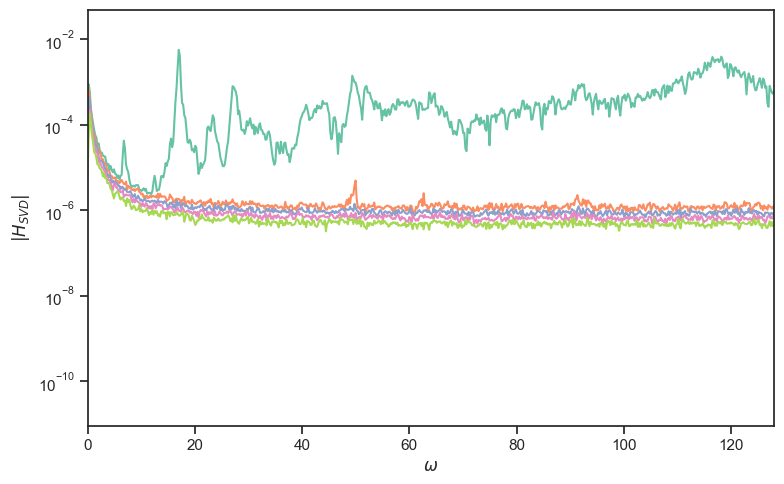

In [ ]:
plt.figure(figsize=(8,5))
plt.semilogy(f, SVS[:,:5]) # plot first 5 SVS only
plt.ylabel('$|H_{{SVD}}|$')
plt.xlabel('$\omega$')
plt.xlim([0, 128])
plt.tight_layout()
if save:
    plt.savefig(save_dir+'singular_spectrum.png')

In [ ]:
# perform SSI 

### you should experiment with these:
sensor_idx = slice(None) # will be slow for all sensors
decimate_factor = 5 # speed up by increasing this
max_order = 50
compute_orders = -1 # -1 => compute all orders
###


y_dc = Y[sensor_idx, ::decimate_factor]
dt_decimated = dt * decimate_factor
opts = {
    "max_model_order": max_order,
    "model_order": compute_orders,
    "dt": dt_decimated,
}
alg = ssi.SSI(opts)
props = alg(y_dc)

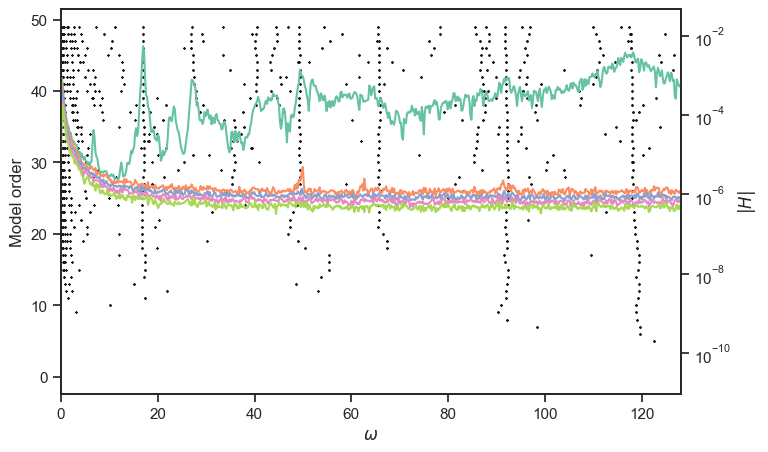

In [ ]:
plt.figure(figsize=(8,5))
for i, order in enumerate(props):
    wns = order[0] / (2 * np.pi)
    wns = wns[order[1] > 0]
    plt.scatter(wns, [i] * len(wns), s=1, marker="x", c="k")
plt.ylabel('Model order')
plt.xlabel('$\omega$')
plt.gca().twinx().semilogy(f, SVS[:, :5], label='SVS')
plt.xlim([0, 128])
plt.ylabel('$|H|$')
if save:
    plt.savefig(save_dir+'SSI_consistency.png')


Suggested next steps / exercises

- Explore different ranges and modes for RFP
- Compare RFP on different sensor locations
- Cmpare the results of SSI with fewer sensors
